In [1]:
"""
TO BE ADDED:

- GridSearchCV
- Feature importance

"""


# Data wrangling libraries
import pandas as pd
import numpy as np
import time

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing libraries
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA

# Regression libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


# Metric libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.expand_frame_repr', False) # print all columns and in the same line
pd.set_option('display.max_colwidth', None) # display the full content of each cell
pd.set_option('display.float_format', lambda x: '%.3f' %x) # floats to be displayed with 3 decimal places

In [2]:
df = pd.read_csv("data_cleaned.csv")
#df = df.drop(columns=['postcode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38986 entries, 0 to 38985
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedroomcount               38986 non-null  float64
 1   postcode                   38986 non-null  int64  
 2   habitablesurface           38986 non-null  int64  
 3   haslift                    38986 non-null  int64  
 4   hasgarden                  38986 non-null  int64  
 5   hasswimmingpool            38986 non-null  int64  
 6   hasterrace                 38986 non-null  int64  
 7   price                      38986 non-null  float64
 8   hasparking                 38986 non-null  int64  
 9   epcscore_encoded           38986 non-null  float64
 10  buildingcondition_encoded  38986 non-null  float64
 11  region_Brussels            38986 non-null  float64
 12  region_Flanders            38986 non-null  float64
 13  region_Wallonia            38986 non-null  flo

In [3]:
# Set the datasets for analysis and the target variable
df_all = df
df_hs = df[df['type_encoded'] == 1]  # Houses
df_apt = df[df['type_encoded'] == 0]  # Apartments

target = 'price'

In [4]:
numVar = [target, 'bedroomcount', 'habitablesurface']
numVar

['price', 'bedroomcount', 'habitablesurface']

In [5]:
def makeBoxplot(var):

    plt.figure(figsize=(5, 2))
    plt.boxplot(df[var], vert=False, patch_artist=True, boxprops=dict(alpha=0.8),
                medianprops=dict(color='white'))

    plt.title(f'Boxplot of {var.capitalize()}', fontsize=14, fontweight='bold')
    plt.ylabel("")
    plt.xlabel("")
    plt.yticks([])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


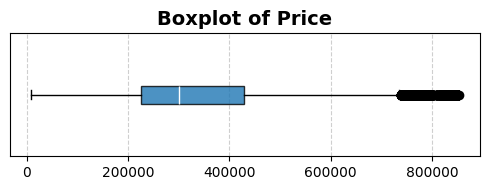

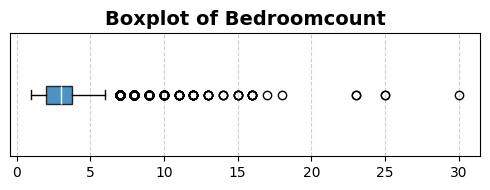

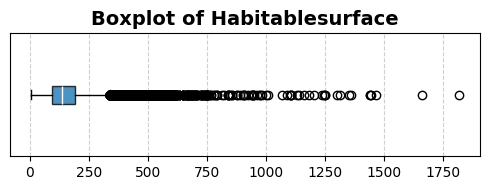

In [6]:
for var in numVar:
    makeBoxplot(var)

In [7]:
def splitDF(df, target):
    # Select target
    y = df[target]
    # Select predictors
    X = df.drop([target], axis=1)
    return X, y


In [8]:
def regResults(df, obs, name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Return a dictionary with the metrics
    return {
        "Dataset": df,
        "Observations": obs,
        "Model": name,
        "R² Score": r2,
        "MAE": mae,
        "RMSE": rmse
    }


In [9]:
def plotPredictions(df, name, y_true, y_pred):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.title(f"{name} - {df} — Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# REGRESSION MODELS

In [10]:
cv = KFold(n_splits=10, shuffle=True, random_state=123)

results = []

models = {
    "Linear": LinearRegression(),
    "LightGBM": lgb.LGBMRegressor(objective='regression', metric='l2', verbosity=-1),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=123),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingRegressor(random_state=123),
    "XGBoost": XGBRegressor(n_estimators=500, random_state=123)
}

datasets = {
    "All Properties": df_all,
    "Only Houses": df_hs,
    "Only Apartments": df_apt
}

def runModels(datasets, obs, models, cv):
    for dataset_name, data in datasets.items():
        X, y = splitDF(data, target)

        for model_name, model in models.items():

            if model_name in ["Linear", "Ridge", "Lasso", "ElasticNet"]:
                pipeline = make_pipeline(StandardScaler(), model)
            else:
                pipeline = make_pipeline(model)

            y_pred = cross_val_predict(pipeline, X, y, cv=cv)
            results.append(regResults(dataset_name, obs, model_name, y, y_pred))
            
    results_df = pd.DataFrame(results)
    return results_df


In [11]:
results_df = runModels(datasets, "raw", models, cv)
print("\nSummary of Regression Results:")
print(results_df.sort_values(by=["Dataset", "RMSE"]))


Summary of Regression Results:
            Dataset Observations              Model  R² Score       MAE       RMSE
1    All Properties          raw           LightGBM     0.728 61836.249  86091.020
8    All Properties          raw            XGBoost     0.717 61917.316  87740.962
6    All Properties          raw      Random Forest     0.708 63465.052  89233.123
7    All Properties          raw  Gradient Boosting     0.673 69120.202  94325.628
2    All Properties          raw              Ridge     0.511 84541.637 115358.719
3    All Properties          raw              Lasso     0.511 84541.558 115358.724
0    All Properties          raw             Linear     0.511 84541.557 115358.724
4    All Properties          raw         ElasticNet     0.511 84752.461 115438.809
5    All Properties          raw      Decision Tree     0.427 86043.719 124887.618
19  Only Apartments          raw           LightGBM     0.772 48967.063  70701.089
26  Only Apartments          raw            XGBoost    

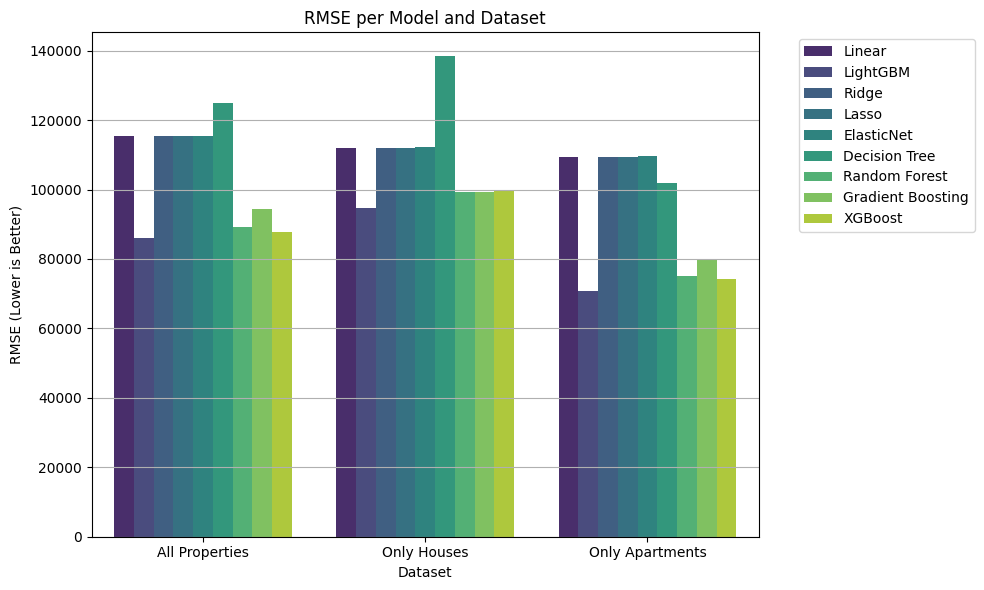

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="Dataset", y="RMSE", hue="Model",
    palette="viridis"
)
plt.title("RMSE per Model and Dataset")
plt.ylabel("RMSE (Lower is Better)")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

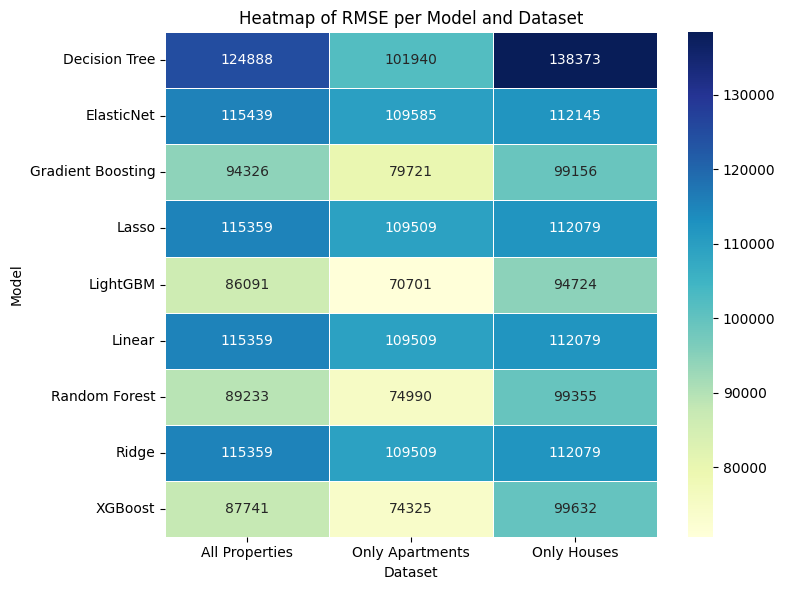

In [13]:
pivot_df = results_df.pivot(index="Model", columns="Dataset", values="RMSE")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of RMSE per Model and Dataset")
plt.ylabel("Model")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()


# PARAMETRIZING XGBOOST

XGBoost shows the best results for all 3 datasets  
Let's fine tuning the XGBoost algorithm

In [14]:
start = time.time()

for dataset_name, data in datasets.items():

    # Split data into train and test as needed to run cross_val_predict
    X, y = splitDF(data, target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # Set hyperparameter grid
    xgb_params = {
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "n_estimators": [100, 500, 1000, 1500, 2000],
        "max_depth": [3, 6, 10, 15],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }

    # Initialize model
    xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=123)

    # Tune hyperparameters
    xgb_search = RandomizedSearchCV(
        xgb_model, xgb_params,
        n_iter=10, cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1, verbose=1,
        random_state=123
    )

    xgb_search.fit(X_train, y_train)

    # Extract and print best parameters
    best_xgb_params = xgb_search.best_params_
    print(f"\nBest Hyperparameters for {dataset_name} running XGBoost:")
    for param, value in best_xgb_params.items():
        print(f"\t{param}: {value}")

    # Predict on test set using the best model
    best_xgb = xgb_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)


    # Predict on test set using the best model
    best_xgb = xgb_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)

    newResult = regResults(dataset_name, "RandomizedSearchCV", "XGBoost", y_test, y_pred_xgb)
    results_df = pd.concat([results_df, pd.DataFrame([newResult])], ignore_index=True)

end = time.time()
code_run = (end - start) / 60
print(f"\nIt took {code_run:.2f} minutes to run the code.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for All Properties running XGBoost:
	subsample: 1.0
	n_estimators: 1500
	max_depth: 6
	learning_rate: 0.05
	colsample_bytree: 0.8
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for Only Houses running XGBoost:
	subsample: 0.8
	n_estimators: 1500
	max_depth: 3
	learning_rate: 0.05
	colsample_bytree: 0.8
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for Only Apartments running XGBoost:
	subsample: 0.8
	n_estimators: 1500
	max_depth: 3
	learning_rate: 0.05
	colsample_bytree: 0.8

It took 10.10 minutes to run the code.


In [15]:
start = time.time()

for dataset_name, data in datasets.items():

    # Split data into train and test as needed to run cross_val_predict
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # Further split training data into training and validation sets for early stopping
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=123)

    # Set hyperparameter grid
    xgb_params = {
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "n_estimators": [100, 500, 1000, 1500, 2000],
        "max_depth": [3, 6, 10, 15],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }

    # Initialize model
    xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', early_stopping_rounds=50, random_state=123)

    # Tune hyperparameters
    xgb_search = RandomizedSearchCV(
        xgb_model, xgb_params,
        n_iter=10, cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1, verbose=1,
        random_state=123
    )

    xgb_search.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Extract and print best parameters
    best_xgb_params = xgb_search.best_params_
    print(f"\nBest Hyperparameters for {dataset_name} running XGBoost:")
    for param, value in best_xgb_params.items():
        print(f"\t{param}: {value}")

    # Predict on test set using the best model
    best_xgb = xgb_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)

    newResult = regResults(dataset_name, "RandomizedSearchCV + EarlyStopping", "XGBoost", y_test, y_pred_xgb)
    results_df = pd.concat([results_df, pd.DataFrame([newResult])], ignore_index=True)


end = time.time()
code_run = (end - start) / 60
print(f"\nIt took {code_run:.2f} minutes to run the code.")

print("\nSummary of Regression Results:")
print(results_df.sort_values(by=["Dataset", "RMSE"]))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for All Properties running XGBoost:
	subsample: 1.0
	n_estimators: 1500
	max_depth: 6
	learning_rate: 0.05
	colsample_bytree: 0.8
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for Only Houses running XGBoost:
	subsample: 1.0
	n_estimators: 1500
	max_depth: 6
	learning_rate: 0.05
	colsample_bytree: 0.8
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for Only Apartments running XGBoost:
	subsample: 1.0
	n_estimators: 1500
	max_depth: 6
	learning_rate: 0.05
	colsample_bytree: 0.8

It took 1.53 minutes to run the code.

Summary of Regression Results:
            Dataset                        Observations              Model  R² Score       MAE       RMSE
30   All Properties  RandomizedSearchCV + EarlyStopping            XGBoost     0.768 49216.860  71661.190
27   All Properties                  RandomizedSearchCV            XGBoost     0

In [16]:
def remove_IQRoutliers(df, columns):
    df_clean = df.copy()
    initial_rows = df_clean.shape[0]

    for col in columns:
        if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col]):
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Create a boolean mask for values that are NOT outliers
            # Keep values within the bounds
            # We'll drop rows where ANY of the specified columns have an outlier
            outlier_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            df_clean = df_clean[~outlier_mask] # Keep rows where the value is NOT an outlier
        else:
            print(f"Warning: Column '{col}' not found or is not numeric. Skipping outlier removal for this column.")

    final_rows = df_clean.shape[0]
    print(f"Removed {initial_rows - final_rows} rows containing outliers from specified columns.")
    return df_clean



In [17]:
# Remove outliers
df_cleaned = remove_IQRoutliers(df, numVar)

print("Cleaned DataFrame shape:", df_cleaned.shape)

Removed 5411 rows containing outliers from specified columns.
Cleaned DataFrame shape: (33575, 15)


In [18]:
# Set the datasets for analysis
df_all = df_cleaned
df_hs = df_cleaned[df_cleaned['type_encoded'] == 1]  # Houses
df_apt = df_cleaned[df_cleaned['type_encoded'] == 0]  # Apartments

datasets = {
    "All Properties": df_all,
    "Only Houses": df_hs,
    "Only Apartments": df_apt
}

results_df = runModels(datasets, "No outliers", models, cv)
print("\nSummary of Regression Results:")
print(results_df.sort_values(by=["Dataset", "RMSE"]))




Summary of Regression Results:
            Dataset Observations              Model  R² Score       MAE       RMSE
28   All Properties  No outliers           LightGBM     0.715 53064.714  72232.909
35   All Properties  No outliers            XGBoost     0.700 53326.025  74088.094
33   All Properties  No outliers      Random Forest     0.690 54728.158  75335.931
34   All Properties  No outliers  Gradient Boosting     0.655 59210.615  79537.745
1    All Properties          raw           LightGBM     0.728 61836.249  86091.020
8    All Properties          raw            XGBoost     0.717 61917.316  87740.962
6    All Properties          raw      Random Forest     0.708 63465.052  89233.123
29   All Properties  No outliers              Ridge     0.521 70594.141  93643.140
30   All Properties  No outliers              Lasso     0.521 70594.134  93643.142
27   All Properties  No outliers             Linear     0.521 70594.132  93643.142
31   All Properties  No outliers         ElasticNet    

In [19]:
# PCA
# n_components=2	Keep only the top 2 components
# n_components=0.95	Keep enough components to explain 95% of the variance
# n_components='mle'	Let PCA choose the optimal number using MLE (only for full SVD)
# Omitted	Keep all components (just rotates them)

# Dictionary to hold PCA-transformed datasets
datasets_pca = {}

for name, df in datasets.items():
    
    X, y = splitDF(df, target)

    # Standardize predictors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=0.95) # keep 95% variance
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame with principal components
    df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
    df_pca[target] = y.values  # add target column back

    # Save transformed dataset
    datasets_pca[name] = df_pca

# Run models with PCA
results_df = runModels(datasets_pca, "PCA", models, cv)

print("\nSummary of Regression Results:")
print(results_df.sort_values(by=["Dataset", "RMSE"]))


Summary of Regression Results:
           Dataset Observations              Model  R² Score       MAE       RMSE
28  All Properties  No outliers           LightGBM     0.715 53064.714  72232.909
35  All Properties  No outliers            XGBoost     0.700 53326.025  74088.094
33  All Properties  No outliers      Random Forest     0.690 54728.158  75335.931
34  All Properties  No outliers  Gradient Boosting     0.655 59210.615  79537.745
1   All Properties          raw           LightGBM     0.728 61836.249  86091.020
..             ...          ...                ...       ...       ...        ...
12     Only Houses          raw              Lasso     0.574 83935.740 112079.178
13     Only Houses          raw         ElasticNet     0.573 84181.158 112145.390
41     Only Houses  No outliers      Decision Tree     0.328 84530.483 114968.668
68     Only Houses          PCA      Decision Tree     0.230 91068.706 123118.364
14     Only Houses          raw      Decision Tree     0.350 99464

In [21]:
r = results_df.sort_values(by=["Dataset", "RMSE"])
r.to_csv('Regression_scores.csv', index=False)